In [21]:
# important packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# for data preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# pipeline !!!
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin   # avoid fit_transform()

# model fitting
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor

# model evalueation and cross-validation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# choose best model and grid search
from sklearn.model_selection import GridSearchCV

In [22]:
# read data and quick look
buy = pd.read_csv('dataset/BlackFriday.csv')
buy.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [23]:
buy.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.375770e+05,537577.00000,537577.000000,537577.000000,370591.000000,164278.000000,537577.000000
mean,1.002992e+06,8.08271,0.408797,5.295546,9.842144,12.669840,9333.859853
std,1.714393e+03,6.52412,0.491612,3.750701,5.087259,4.124341,4981.022133
min,1.000001e+06,0.00000,0.000000,1.000000,2.000000,3.000000,185.000000
25%,1.001495e+06,2.00000,0.000000,1.000000,5.000000,9.000000,5866.000000
50%,1.003031e+06,7.00000,0.000000,5.000000,9.000000,14.000000,8062.000000
75%,1.004417e+06,14.00000,1.000000,8.000000,15.000000,16.000000,12073.000000
max,1.006040e+06,20.00000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [24]:
# see the distribution and info for the categorical data
buy.describe(include=['O'])

,Product_ID,Gender,Age,City_Category,Stay_In_Current_City_Years
count,537577,537577,537577,537577,537577
unique,3623,2,7,3,5
top,P00265242,M,26-35,B,1
freq,1858,405380,214690,226493,189192


In [25]:
buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [26]:
# before doing data cleaning, I want to drop user_id because I believe it is useless for predict purchase. And from
# infor of the data, we need to convert some types of some features.

In [27]:
# delete 'User_ID' becuase of useless
# delete 'Product_Category_3' because of to many missing value
buy = buy.drop(['User_ID', 'Product_Category_3'], axis=1)
buy.shape

(537577, 10)

# Explore some features and convert some features manually

# Gender

In [28]:
# see Gender's influence on Purchase
buy[['Gender', 'Purchase']].groupby(['Gender'], as_index=False).mean()
# female tend to buy more than male on average

,Gender,Purchase
0,F,8809.761349
1,M,9504.771713


In [29]:
# convert gender to numerical value
buy['Gender'] = buy['Gender'].map({'F':1, 'M':0}).astype(int)

# Age

In [30]:
# see different age range's influence on purchase
age = buy[['Age', 'Purchase']].groupby(['Age'], as_index=False).mean()
age

,Age,Purchase
0,0-17,9020.126878
1,18-25,9235.197575
2,26-35,9314.588970
3,36-45,9401.478758
4,46-50,9284.872277
5,51-55,9620.616620
6,55+,9453.898579


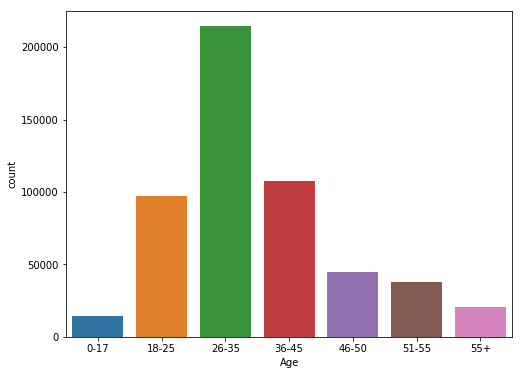

In [31]:
# plot count plot for categorical feature Age
plt.figure(figsize=(8,6))
sns.countplot(buy['Age'], order=list(age.Age))

In [32]:
# convert Age to int value
age_mapping = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}

buy['Age'] = buy['Age'].map(age_mapping)
buy.head()

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,P00069042,1,0,10,A,2,0,3,NaN,8370
1,P00248942,1,0,10,A,2,0,1,6.0,15200
2,P00087842,1,0,10,A,2,0,12,NaN,1422
3,P00085442,1,0,10,A,2,0,12,14.0,1057
4,P00285442,0,6,16,C,4+,0,8,NaN,7969


# City Category and years of stay

In [33]:
# look at city's influence on purchase
city = buy[['City_Category', 'Purchase']].groupby(['City_Category'], as_index=False).mean()
city

,City_Category,Purchase
0,A,8958.011014
1,B,9198.657848
2,C,9844.441855


In [34]:
buy[['Stay_In_Current_City_Years', 'Purchase']].groupby(['Stay_In_Current_City_Years'], as_index=False).mean()

,Stay_In_Current_City_Years,Purchase
0,0,9247.238625
1,1,9319.865095
2,2,9397.607316
3,3,9350.685121
4,4+,9346.370158


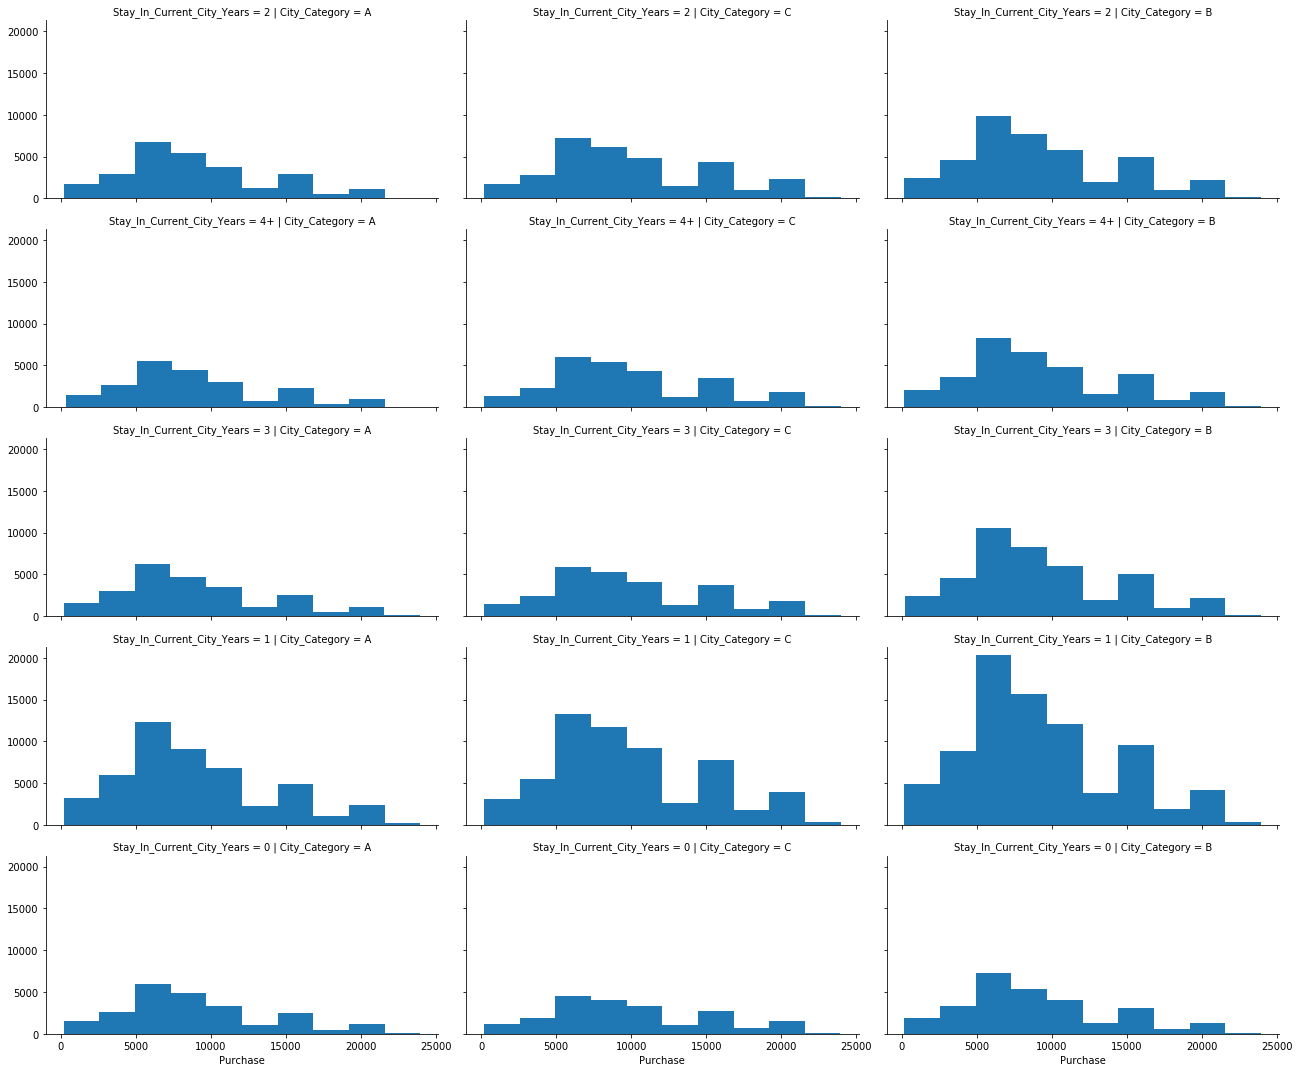

In [35]:
grid = sns.FacetGrid(buy, col='City_Category', row='Stay_In_Current_City_Years', height=3, aspect=2)
grid.map(plt.hist, 'Purchase')
grid.add_legend()

In [36]:
# combine city and years of stay, then do 1hot transform
buy['city+year'] = buy['City_Category'] + buy['Stay_In_Current_City_Years']

In [37]:
# delete city and years
buy = buy.drop(['City_Category', 'Stay_In_Current_City_Years'], axis=1)
buy.head()

,Product_ID,Gender,Age,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Purchase,city+year
0,P00069042,1,0,10,0,3,NaN,8370,A2
1,P00248942,1,0,10,0,1,6.0,15200,A2
2,P00087842,1,0,10,0,12,NaN,1422,A2
3,P00085442,1,0,10,0,12,14.0,1057,A2
4,P00285442,0,6,16,0,8,NaN,7969,C4+


# Product_Category_2

In [38]:
# fill na with median and convert it to int
median_p2 = buy['Product_Category_2'].median()
buy['Product_Category_2'].fillna(median_p2, inplace=True)
buy['Product_Category_2'] = buy['Product_Category_2'].astype(int)

# strat sampling

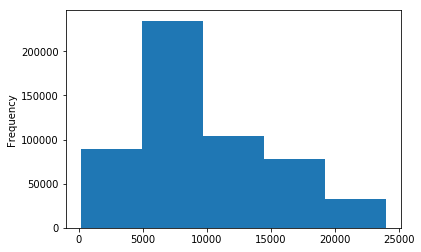

In [39]:
# take a look at the distribution of purchase
buy.Purchase.plot(kind='hist', bins=5)

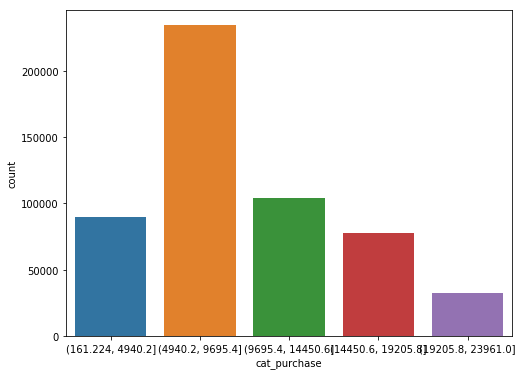

In [78]:
# generate train and test data by new feature cat_purchase
# pd.cut() could convert purchase to groups of purchase ranges
buy['cat_purchase'] = pd.cut(buy.Purchase, 5)
plt.figure(figsize=(8,6))
sns.countplot(buy['cat_purchase'])

# convert cat value to int
buy['cat_purchase'] = pd.cut(buy.Purchase, 5, labels=[1,2,3,4,5])
buy['cat_purchase'] = buy['cat_purchase'].astype(int)

In [42]:
buy['cat_purchase'].value_counts()/len(buy) 

2    0.436315
3    0.193756
1    0.166324
4    0.143914
5    0.059690
Name: cat_purchase, dtype: float64

In [43]:
# split data by feature cat_purchase
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(buy, buy['cat_purchase']):
    strat_train_set = buy.loc[train_index]
    strat_test_set = buy.loc[test_index]
    
# alternatively, we can split the data in one line code
# X = buy.drop(['Purchase'], axis=1)
# y = buy['Purchase'].copy()
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [44]:
strat_train_set.shape, strat_test_set.shape

((430061, 10), (107516, 10))

# pipelines to do data cleaning

In [45]:
strat_train_set.head()

,Product_ID,Gender,Age,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Purchase,city+year,cat_purchase
526987,P00074242,0,1,4,0,5,9,5348,B1,2
514327,P00303842,1,3,0,1,5,8,6948,A0,2
454004,P00111142,0,1,4,1,1,15,11419,A1,3
512302,P00178642,0,2,7,1,5,15,6902,B1,2
22984,P00000542,0,3,20,1,5,9,7048,B4+,2


In [46]:
X_train = strat_train_set.drop(['Purchase', 'cat_purchase'], axis=1)
#X_train = strat_train_set.drop(['Purchase', 'cat_purchase', 'Product_ID'], axis=1)
y_train = strat_train_set['Purchase'].copy()

X_train.head()

,Product_ID,Gender,Age,Occupation,Marital_Status,Product_Category_1,Product_Category_2,city+year
526987,P00074242,0,1,4,0,5,9,B1
514327,P00303842,1,3,0,1,5,8,A0
454004,P00111142,0,1,4,1,1,15,A1
512302,P00178642,0,2,7,1,5,15,B1
22984,P00000542,0,3,20,1,5,9,B4+


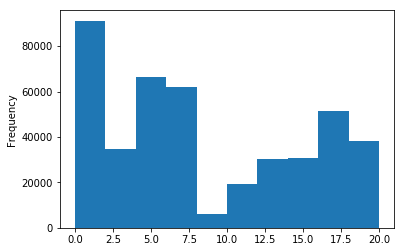

In [47]:
X_train.Occupation.plot(kind='hist')

In [48]:
# select numerical featuers and categorical featrues from dataframe
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [49]:
num_attribs = ['Occupation', 'Product_Category_1', 'Product_Category_2']
cat_attribs = ['Product_ID', 'Gender', 'Age', 'Marital_Status', 'city+year']
#cat_attribs = ['Gender', 'Age', 'Marital_Status', 'city+year']

# pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    #('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# pipeline for categorical featrues
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])


# combine two pipelines
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipelien', cat_pipeline),
])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_train_prepared

array([[-0.62660021, -0.07988138, -0.13789979, ...,  0.        ,
         0.        ,  0.        ],
       [-1.23958065, -0.07988138, -0.37362656, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62660021, -1.1464321 ,  1.27646085, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.93309043, -0.07988138, -0.37362656, ...,  1.        ,
         0.        ,  0.        ],
       [-0.16686489,  3.38640846, -0.13789979, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13962533, -1.1464321 , -1.78798719, ...,  0.        ,
         0.        ,  0.        ]])

In [50]:
X_train_prepared.shape, y_train.shape

((430061, 3622), (430061,))

# Model fitting

In [29]:
sgd_reg = SGDRegressor(penalty='elasticnet')
sgd_reg.fit(X_train_prepared, y_train)

purchase_pred = sgd_reg.predict(X_train_prepared)
sgd_rmse = np.sqrt(mean_squared_error(y_train, purchase_pred))
sgd_rmse

/Users/xisizhang/HOME/ml/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


3602.187002334281

In [36]:
# linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

purchase_pred = lin_reg.predict(X_train_prepared)
lin_rmse = np.sqrt(mean_squared_error(y_train, purchase_pred))
lin_rmse

4699.681735482854

In [37]:
# decision tree 
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_prepared, y_train)

purchase_pred = tree_reg.predict(X_train_prepared)
tree_rmse = np.sqrt(mean_squared_error(y_train, purchase_pred))
tree_rmse

2533.0087818099682

In [38]:
# help to display scores
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())

# random forest
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_prepared, y_train)
forest_pred = forest_reg.predict(X_train_prepared)

forest_scores = cross_val_score(forest_reg, X_train_prepared, y_train, scoring='neg_mean_squared_error', cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

/Users/xisizhang/HOME/ml/env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores: [3052.04271577 3062.89424646 3085.8991451  3063.81374006 3070.08701829]
Mean: 3066.947373136109
Standard Deviation: 11.112365503869553


# GridSearchcv

In [116]:
param_grid = [
    {'n_estimators': [10, 30], 'max_features': [4,6,8,10]},
    {'bootstrap': [False], 'n_estimators': [10, 30], 'max_features': [4,6,8]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 30], 'max_features': [4, 6, 8, 10]}, {'bootstrap': [False], 'n_estimators': [10, 30], 'max_features': [4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [117]:
grid_search.best_params_

{'max_features': 10, 'n_estimators': 30}

In [118]:
cvres = grid_search.cv_results_
for mean_score, params, in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

3175.3450199058207 {'max_features': 4, 'n_estimators': 10}
3126.888579283184 {'max_features': 4, 'n_estimators': 30}
3099.1272355866686 {'max_features': 6, 'n_estimators': 10}
3072.477482833298 {'max_features': 6, 'n_estimators': 30}
3076.42380560295 {'max_features': 8, 'n_estimators': 10}
3051.7415410167478 {'max_features': 8, 'n_estimators': 30}
3067.977884942247 {'max_features': 10, 'n_estimators': 10}
3044.4664794900314 {'max_features': 10, 'n_estimators': 30}
3196.1057811410265 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
3186.330817657548 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}
3149.5858892878828 {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}
3140.690592297397 {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}
3130.9396963821796 {'bootstrap': False, 'max_features': 8, 'n_estimators': 10}
3121.3745836098637 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}


In [119]:
cat_encoder = cat_pipeline.named_steps['cat_encoder']
temp = [list(x) for x in cat_encoder.categories_]
cat_1hot_attribs = []
for x in temp:
    cat_1hot_attribs += x
attribs = num_attribs + cat_1hot_attribs

In [120]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.0672662 , 0.7411315 , 0.11150949, 0.00264643, 0.0036534 ,
       0.00161941, 0.00400409, 0.00507474, 0.00466652, 0.00320778,
       0.00257397, 0.00230815, 0.00516174, 0.00506887, 0.00243811,
       0.00277191, 0.00240447, 0.00260168, 0.00208259, 0.00277736,
       0.00375123, 0.003175  , 0.00340791, 0.00287342, 0.00242483,
       0.00251829, 0.00236619, 0.00254966, 0.00196507])

In [121]:
sorted(zip(feature_importances, attribs), reverse=True)

[(0.7411314968856441, 'Product_Category_1'),
 (0.11150949235490983, 'Product_Category_2'),
 (0.06726619516574399, 'Occupation'),
 (0.005161744380852534, 0),
 (0.005074739185232379, '26-35'),
 (0.0050688669253338425, 1),
 (0.004666520461471294, '36-45'),
 (0.004004091879172504, '18-25'),
 (0.003751233113819258, 'B1'),
 (0.003653402763516421, 'M'),
 (0.0034079102981023853, 'B3'),
 (0.0032077802347007284, '46-50'),
 (0.0031749983196942295, 'B2'),
 (0.002873421663389913, 'B4+'),
 (0.0027773583572054663, 'B0'),
 (0.002771910637595877, 'A1'),
 (0.002646430847595506, 'F'),
 (0.002601680503179161, 'A3'),
 (0.0025739712267577705, '51-55'),
 (0.0025496618371924325, 'C3'),
 (0.002518294020361016, 'C1'),
 (0.0024381055293241282, 'A0'),
 (0.0024248276379518763, 'C0'),
 (0.0024044677483797947, 'A2'),
 (0.0023661903387272062, 'C2'),
 (0.0023081486691911984, '55+'),
 (0.002082587580790255, 'A4+'),
 (0.0019650664148206523, 'C4+'),
 (0.0016194050193441964, '0-17')]

In [91]:
strat_test_set.head()

,Product_ID,Gender,Age,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Purchase,city+year,cat_purchase
246440,P00182242,0,3,17,0,1,5,11654,A1,"(9695.4, 14450.6]"
97259,P00345242,1,2,0,0,5,11,3567,A1,"(161.224, 4940.2]"
271910,P00250942,0,1,4,0,11,16,6034,C1,"(4940.2, 9695.4]"
135620,P00240142,0,2,4,0,5,9,8859,B1,"(4940.2, 9695.4]"
157193,P00122542,0,4,18,1,11,9,7602,C4+,"(4940.2, 9695.4]"


In [92]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop(['Purchase', 'cat_purchase', 'Product_ID'], axis=1)
y_test = strat_test_set['Purchase'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [93]:
final_rmse

3031.4260517140256